# Flowers Recongnition

### Import Neccessary Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
print(f"TensorFlow Version: {tf.__version__}")

2024-11-14 11:35:06.974329: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731555306.988317   34998 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731555306.992519   34998 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 11:35:07.007312: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/divinevalleys/miniconda3/envs/tf-wsl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Ple

TensorFlow Version: 2.18.0


### Data Loading and Preprocessing

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'oxford_flowers102',
    split=['test', 'validation', 'train'],
    shuffle_files=True,
    as_supervised=True,  # Include labels
    with_info=True
)
print(f"Dataset Info:\n{ds_info}")
num_classes = ds_info.features['label'].num_classes
print(f"Number of classes: {num_classes}")

I0000 00:00:1731555313.533419   34998 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21769 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:0a:00.0, compute capability: 8.6


Dataset Info:
tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/da

### Data Visualization

2024-11-14 11:35:19.407158: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2024-11-14 11:35:19.514625: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


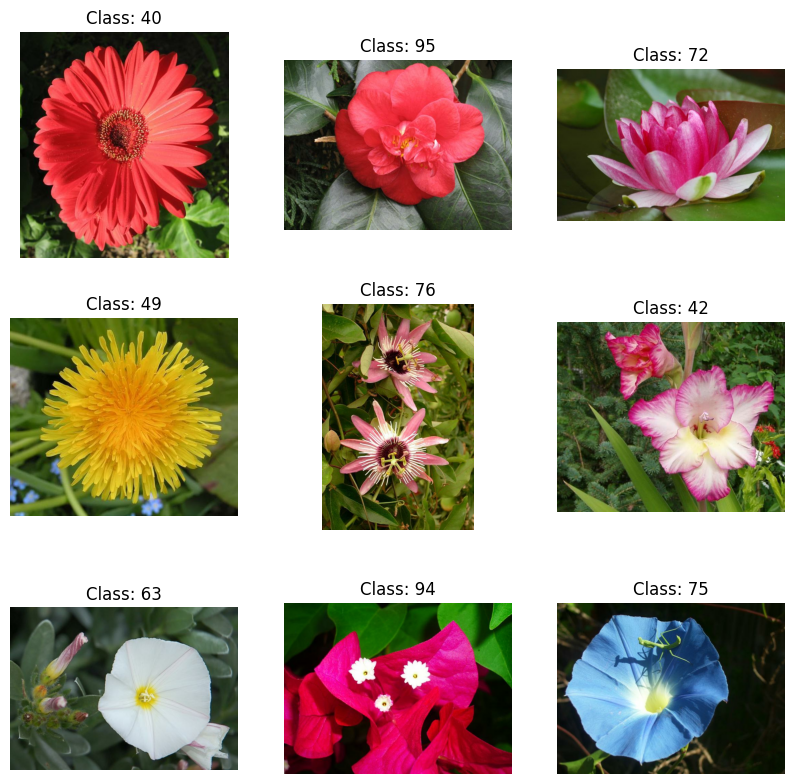

In [4]:
#visualize a few samples from the training set
def visualize_samples(dataset, num_samples=9):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(num_samples)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title(f"Class: {label.numpy()}")
        plt.axis("off")
    plt.show()

visualize_samples(ds_train)


### Data Preprocessing

In [5]:
IMG_SIZE = 224  # You can adjust this size
BATCH_SIZE = 64



In [6]:
def preprocess(image, label):
    # Resize and normalize images
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0  # Normalize to [0,1]
    return image, label


In [7]:
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


### Data Augmentation

In [8]:
# Define data augmentation with input_shape

data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.1, 0.1),
])



/home/divinevalleys/miniconda3/envs/tf-wsl/lib/python3.9/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### CNN architecture

In [9]:
from tensorflow.keras import layers, models, regularizers

num_classes = 102  # Number of flower classes

# Regularization parameter
l2_reg = 1e-4  # You can adjust this value

model = models.Sequential()

# Input Layer with Data Augmentation
model.add(data_augmentation)

# Block 1
model.add(layers.Conv2D(
    32, (3, 3), padding='same', kernel_initializer='he_normal',
    #kernel_regularizer=regularizers.l2(l2_reg)
))
#model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(
    32, (3, 3), padding='same', kernel_initializer='he_normal',
    #kernel_regularizer=regularizers.l2(l2_reg)
))
#model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Dropout(0.25))

# Block 2
model.add(layers.Conv2D(
    64, (3, 3), padding='same', kernel_initializer='he_normal',
    #kernel_regularizer=regularizers.l2(l2_reg)
))
#model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(
    64, (3, 3), padding='same', kernel_initializer='he_normal',
    #kernel_regularizer=regularizers.l2(l2_reg)
))
#model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Dropout(0.25))

# Block 3
model.add(layers.Conv2D(
    128, (3, 3), padding='same', kernel_initializer='he_normal',
    #kernel_regularizer=regularizers.l2(l2_reg)
))
#model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(
    128, (3, 3), padding='same', kernel_initializer='he_normal',
    #kernel_regularizer=regularizers.l2(l2_reg)
))
#model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Dropout(0.25))

# Block 4
model.add(layers.Conv2D(
    256, (3, 3), padding='same', kernel_initializer='he_normal',
    #kernel_regularizer=regularizers.l2(l2_reg)
))
#model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(
    256, (3, 3), padding='same', kernel_initializer='he_normal',
    #kernel_regularizer=regularizers.l2(l2_reg)
))
#model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Dropout(0.5))

# Block 5 (Optional)
# model.add(layers.Conv2D(
#     512, (3, 3), padding='same', kernel_initializer='he_normal',
#     kernel_regularizer=regularizers.l2(l2_reg)
# ))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
# model.add(layers.Conv2D(
#     512, (3, 3), padding='same', kernel_initializer='he_normal',
#     kernel_regularizer=regularizers.l2(l2_reg)
# ))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.5))

# Classification Head
model.add(layers.Flatten())
model.add(layers.Dense(
    1024, activation='relu', kernel_initializer='he_normal',
    #kernel_regularizer=regularizers.l2(l2_reg)
))
#model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

#dense layer
model.add(layers.Dense(
    512, activation='relu', kernel_initializer='he_normal',
    #kernel_regularizer=regularizers.l2(l2_reg)
))
#model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

#dense layer
model.add(layers.Dense(
    256, activation='relu', kernel_initializer='he_normal',
    #kernel_regularizer=regularizers.l2(l2_reg)
))
#model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

#dense layer
model.add(layers.Dense(
    128, activation='relu', kernel_initializer='he_normal',
    #kernel_regularizer=regularizers.l2(l2_reg)
))
#model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    51,381,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,80

 Total params: 53,255,686 (203.15 MB)

 Trainable params: 53,255,686 (203.15 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
#optimizer = keras.optimizers.Adam(learning_rate=1e-2)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [11]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6  # Set a minimum learning rate to prevent it from becoming too low
)

### Training the Model

In [12]:
callbacks = [
    keras.callbacks.EarlyStopping(
        patience=50, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(
        'best_model.keras', save_best_only=True),
    #lr_scheduler
]



In [13]:
epochs = 250  # Adjust the number of epochs as needed

history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=epochs,
    callbacks=callbacks
)


Epoch 1/250


I0000 00:00:1731555402.089797   35351 cuda_dnn.cc:529] Loaded cuDNN version 90300


97/97 ━━━━━━━━━━━━━━━━━━━━ 28s 195ms/step - accuracy: 0.0195 - loss: 5.1194 - val_accuracy: 0.0098 - val_loss: 4.7531
Epoch 2/250
97/97 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - accuracy: 0.0343 - loss: 4.4730 - val_accuracy: 0.0098 - val_loss: 4.7542
Epoch 3/250
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 0.0377 - loss: 4.4463 - val_accuracy: 0.0098 - val_loss: 4.7372
Epoch 4/250
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 0.0377 - loss: 4.4179 - val_accuracy: 0.0098 - val_loss: 4.7226
Epoch 5/250
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 0.0378 - loss: 4.3838 - val_accuracy: 0.0206 - val_loss: 4.6709
Epoch 6/250
97/97 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 0.0640 - loss: 4.2985 - val_accuracy: 0.0176 - val_loss: 4.4591
Epoch 7/250
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.0658 - loss: 4.1108 - val_accuracy: 0.0196 - val_loss: 4.2725
Epoch 8/250
97/97 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 0.0909 - loss: 3.9511 - val_accuracy

### Plot Training History

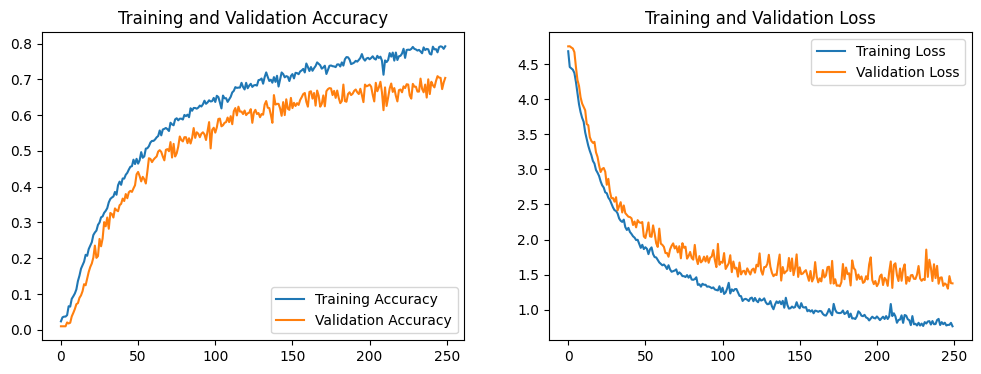

In [14]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)


### Evaluate on the Test Set

In [16]:
test_loss, test_accuracy = model.evaluate(ds_test)
print(f'Test Accuracy: {test_accuracy:.4f}')


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7112 - loss: 1.3737
Test Accuracy: 0.6990


### Make Predictions

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


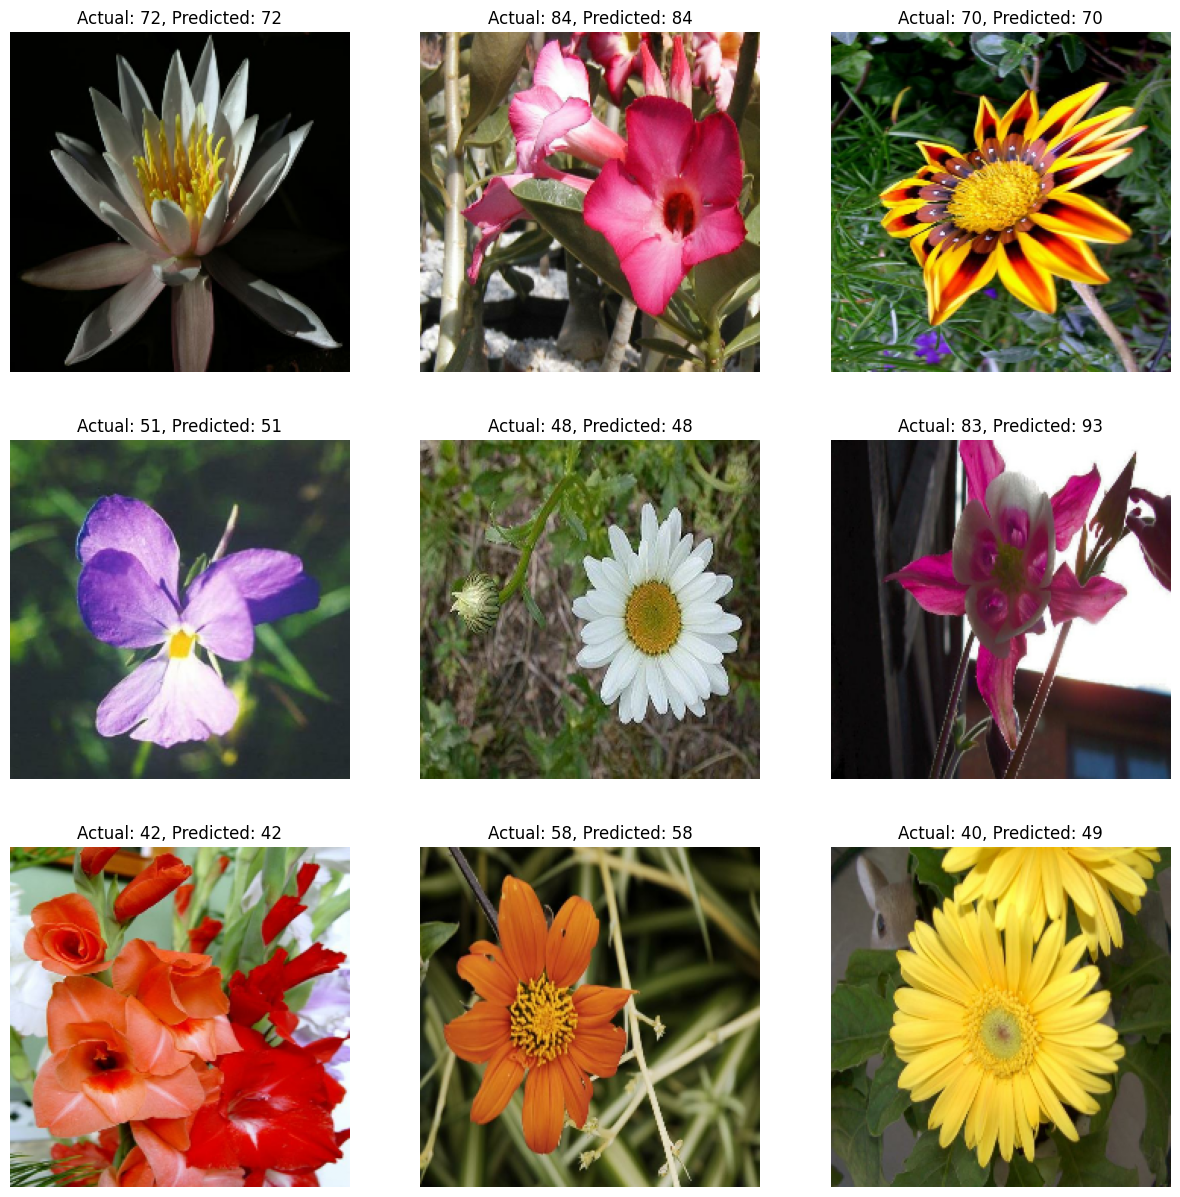

2024-11-14 16:45:48.435936: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
#Visualize 9 predictions
for images, labels in ds_test.take(1):
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    plt.figure(figsize=(15, 15))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        actual_label = labels[i].numpy()
        predicted_label = predicted_labels[i]
        plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")
        plt.axis("off")
    plt.show()


### Save the Model

In [19]:
model.save('flower_classification_model.keras')


In [20]:
loaded_model = keras.models.load_model('flower_classification_model.keras')


In [22]:
loaded_test_loss, loaded_test_accuracy = loaded_model.evaluate(ds_test)
print(f'Loaded Model Test Accuracy: {loaded_test_accuracy*100:.4f}')


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7112 - loss: 1.3737
Loaded Model Test Accuracy: 69.9020
